In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [68]:
!unzip -q "/content/gdrive/My Drive/data.zip"

unzip:  cannot find or open /content/gdrive/My Drive/data.zip, /content/gdrive/My Drive/data.zip.zip or /content/gdrive/My Drive/data.zip.ZIP.


In [69]:
import cv2,os
data_path='data'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]
label_dict=dict(zip(categories,labels))
print(label_dict)
print(labels)
print(categories)

{'with_mask': 0, 'without_mask': 1}
[0, 1]
['with_mask', 'without_mask']


In [70]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)

In [71]:
import numpy as np
import keras
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)
from keras.utils import np_utils
new_target=np_utils.to_categorical(target)

In [72]:
from keras.models import  Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

In [73]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [74]:
 from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,new_target,test_size=0.2)

In [75]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(X_train,Y_train,epochs=10,batch_size=32,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/10
28/28 [==============================] - 67s 2s/step - loss: 0.7350 - accuracy: 0.5466 - val_loss: 0.6677 - val_accuracy: 0.5045
Epoch 2/10
28/28 [==============================] - 66s 2s/step - loss: 0.5493 - accuracy: 0.7261 - val_loss: 0.4574 - val_accuracy: 0.7909
Epoch 3/10
28/28 [==============================] - 66s 2s/step - loss: 0.3979 - accuracy: 0.8227 - val_loss: 0.3833 - val_accuracy: 0.8364
Epoch 4/10
28/28 [==============================] - 66s 2s/step - loss: 0.2720 - accuracy: 0.9034 - val_loss: 0.2780 - val_accuracy: 0.8864
Epoch 5/10
28/28 [==============================] - 66s 2s/step - loss: 0.2017 - accuracy: 0.9307 - val_loss: 0.1811 - val_accuracy: 0.9227
Epoch 6/10
28/28 [==============================] - 65s 2s/step - loss: 0.1907 - accuracy: 0.9227 - val_loss: 0.2432 - val_accuracy: 0.8864
Epoch 7/10
28/28 [==============================] - 66s 2s/step - loss: 0.1595 - accuracy: 0.9432 - val_loss: 0.1585 - val_accuracy: 0.9364
Epoch 8/10
28/28 [==

In [76]:
from sklearn.metrics import classification_report
predIdxs = model.predict(X_test)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(Y_test.argmax(axis=1), predIdxs))
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('model.h5')


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       129
           1       0.97      0.97      0.97       147

    accuracy                           0.96       276
   macro avg       0.96      0.96      0.96       276
weighted avg       0.96      0.96      0.96       276

[INFO] saving mask detector model...


In [77]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[124   5]
 [  5 142]]
acc: 0.9638
sensitivity: 0.9612
specificity: 0.9660


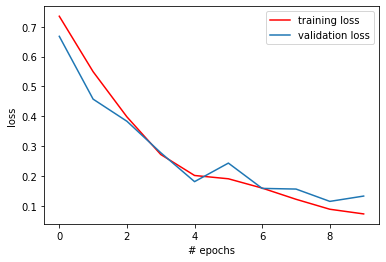

In [78]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


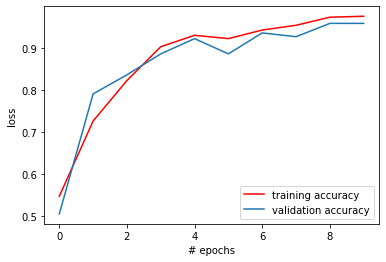

In [79]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()